In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import time
import mahotas as mh
from tqdm.notebook import tqdm
from image.controller import ImageController

/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
dir_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/nina_d1_raw/'

In [5]:
save_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_3/'
log_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_3/log.txt'
plot_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_3/compare_plots/'
sys.stdout = open(log_path, 'w')

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

AttributeError: 'Figure' object has no attribute 'title'

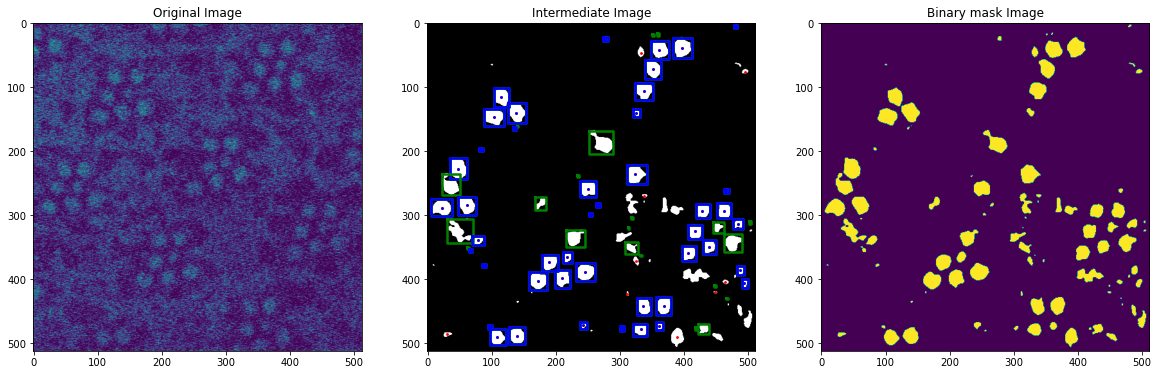

In [6]:
file_count = 1
for file in tqdm(sorted(os.listdir(dir_path))):
    start_time = time.time()
    if file.endswith(".tif"):
        print("Image Name: " + file)
        img_file = os.path.join(dir_path, file)
        data = ImageController.read(img_file)
        normalized_data = ImageController.normalize(data)
        crop_data = ImageController.center_crop(normalized_data, crop_size=(512, 512))
        data_crop = ImageController.center_crop(data, crop_size=(512, 512))
        smoothed_data = ImageController.smooth(crop_data)
        
        threshold_value = int(smoothed_data.mean())
        threshold_start = 1
        threshold_limit = 255
        if (threshold_value - 40 > 1):
            threshold_start = threshold_value - 40
        if (threshold_value + 40 < 255):
            threshold_limit = int(threshold_value) + 40
        
        best_threshold, best_accuracy, num_rhabdomeres = 0, 0, 0
        
        for threshold in tqdm(range(threshold_start, threshold_limit, 1)):
            threshold_data = ImageController.threshold(smoothed_data, threshold_value=threshold)
            labeled_data, nr_count = ImageController.label(threshold_data)
            selected_labeled_data = ImageController.select_large_regions(labeled_data, region_size=750)
            binary_mask_data = ImageController.binary_mask(selected_labeled_data)
            closed_binary_mask_data = ImageController.close_binary_mask(binary_mask_data)
            segmented_image = ImageController.binary_image(closed_binary_mask_data)
            num_pixels = int(np.sum(segmented_image))
            if num_pixels > 5000:
                test_accuracy, test_num_rhabdomeres = ImageController.classify_image_nina(binary_mask_data)
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_threshold = threshold
                    num_rhabdomeres = test_num_rhabdomeres
        
        threshold_data = ImageController.threshold(smoothed_data, threshold_value=best_threshold)
        labeled_data, nr_count = ImageController.label(threshold_data)
        selected_labeled_data = ImageController.select_large_regions(labeled_data, region_size=750)
        binary_mask_data = ImageController.binary_mask(selected_labeled_data)
        closed_binary_mask_data = ImageController.close_binary_mask(binary_mask_data)
        segmented_image = ImageController.binary_image(closed_binary_mask_data)
        num_pixels = int(np.sum(segmented_image))
        
        plot_name = os.path.join(plot_path, file)
        plot_name = plot_name.split('.')[0] + '.png'
        
        ImageController.display_and_save_compare_labeled(data_crop, binary_mask_data, segmented_image, plot_name)
        
        end_time = time.time()
        
        print("Total Time Taken: ", (end_time - start_time), " seconds")
        print("Threshold mean: ", threshold_value)
        print("Threshold best: ", best_threshold)
        print("Accuracy best: ", best_accuracy)
        print("Possible number of rhabdomeres: ", num_rhabdomeres)
        print("Total number of pixels in the mask: ", num_pixels)
        print("Total files processed so far: ", file_count)
        file_count = file_count + 1
        print("---------------------------------------------------------")

In [33]:
import random

mylist = []

for i in range(0,50):
    x = random.randint(1,300)
    mylist.append(x)

In [34]:
mylist = sorted(mylist)

In [35]:
files = os.listdir(file_path)

In [ ]:
from skimage import measure, filters

files = os.listdir(file_path)

for i in tqdm(mylist):
    file = files[i]
    img_file = os.path.join(file_path, file)
    
    data = ImageController.read(img_file)
    ImageController.display(data)
    
    data_crop = ImageController.center_crop(data, crop_size=(512, 512))
    
    normalized_data = ImageController.normalize(data)
    
    crop_data = ImageController.center_crop(normalized_data, crop_size=(512, 512))
    
    smoothed_data = ImageController.smooth(crop_data)
    
    smoothed_data = smoothed_data.astype(np.uint8)
    
    threshold_value = int(smoothed_data.mean())
    threshold_limit = int(threshold_value) + 20
    
    binary_mask_region = data_crop.copy()
    binary_mask = data_crop.copy()
    
    min_accuray = 0
    best_accuray = 0
    best_threshold = 0
    num_rhabdomeres = 0
    
    for threshold in tqdm(range(threshold_value, threshold_limit, 1)):
        threshold_data = ImageController.threshold(smoothed_data, threshold_value = threshold)

        labeled_data, nr_count = ImageController.label(threshold_data)

        sizes = mh.labeled.labeled_size(labeled_data)
        too_small = np.where(sizes > 750)
        selected_labeled_data = mh.labeled.remove_regions(labeled_data, too_small)

        binary_mask_data = ImageController.binary_mask(selected_labeled_data)

        binary_mask_closed = mh.morph.close(binary_mask_data)
        labeled_result, nr_objects_result = mh.label(binary_mask_data)
        labeled_result = mh.labeled.remove_bordering(labeled_result)
        region_sizes = measure.regionprops(labeled_result, intensity_image=binary_mask_closed)

        f, axarr = plt.subplots(1, 3, figsize=(15, 45))
        axarr[1].imshow(labeled_result, cmap='gray')

        num_circles = 0
        num_sq = 0
        num_circle_sq = 0
        
        for region in region_sizes:
            x1, y1 = region.centroid
            minr, minc, maxr, maxc = region.bbox
            x = maxc - minc
            y = maxr - minr
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            circularity = (region.perimeter ** 2) / (4 * math.pi * region.area);
            if circularity < 1.3 and circularity > 0.7:
                axarr[1].plot(y1, x1, '.r', markersize=3.5)
                num_circles += 1
            if x/y >= .7 and x/y <= 1.3:
                axarr[1].plot(bx, by, '-g', linewidth=2.5)
                num_sq += 1
            if circularity < 1.3 and circularity > 0.7 and x/y >= .7 and x/y <= 1.3:
                axarr[1].plot(y1, x1, '.b', markersize=3.5)
                axarr[1].plot(bx, by, '-b', linewidth=2.5)
                num_circle_sq += 1
        axarr[0].imshow(data_crop)
        axarr[2].imshow(binary_mask_data)
        plt.show()
        
        accuracy = (len(region_sizes) - num_circle_sq)/len(region_sizes)
        
        if accuracy > min_accuray:
            best_accuray = accuracy
            min_accuray = best_accuray
            binary_mask_region = labeled_result
            binary_mask = binary_mask_data
            best_threshold = threshold
            num_rhabdomeres = num_circle_sq
    
    f, ax = plt.subplots(1, 2, figsize=(15, 30))
    ax[0].imshow(data_crop)
    ax[1].imshow(binary_mask)
    plt.show()
    print("best threshold: ", threshold)
    print("possible number of rhabdomeres: ", num_rhabdomeres)
    print("accuracy: ", best_accuray)
    print("----------------------------------------------------------------")

In [135]:
files[mylist[2]]

'000000_000000_001749_000000.tif'

In [136]:
file_path

'/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/nina_d1_raw/'

In [137]:
img_file = os.path.join(file_path, files[mylist[2]])

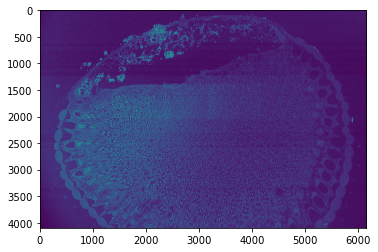

In [138]:
data = ImageController.read(img_file)
ImageController.display(data)

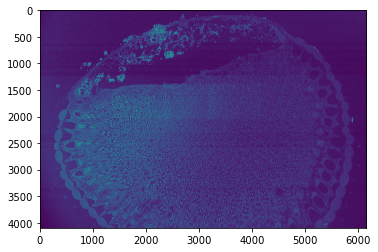

In [139]:
normalized_data = ImageController.normalize(data)
ImageController.display(normalized_data)

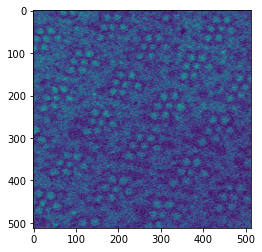

In [140]:
crop_data = ImageController.center_crop(normalized_data, crop_size=(512, 512))
ImageController.display(crop_data)

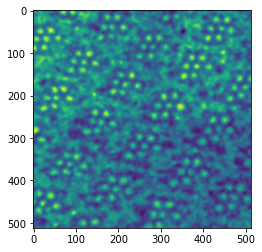

In [141]:
smoothed_data = ImageController.smooth(crop_data)
ImageController.display(smoothed_data)

In [142]:
smoothed_data = smoothed_data.astype(np.uint8)

In [143]:
smoothed_data.min(), smoothed_data.max(), smoothed_data.mean(), mh.otsu(smoothed_data)

(13, 92, 44.859375, 46)

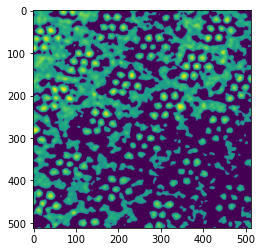

In [144]:
threshold_data = ImageController.threshold(smoothed_data, threshold_value=smoothed_data.mean())
ImageController.display(threshold_data)

In [145]:
labeled_data, nr_count = ImageController.label(threshold_data)

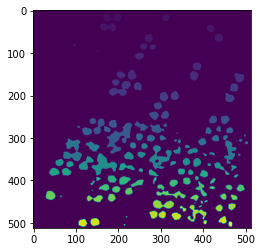

In [146]:
imshow(labeled_data)

In [147]:
sizes = mh.labeled.labeled_size(labeled_data)
too_small = np.where(sizes > 750)
selected_labeled_data = mh.labeled.remove_regions(labeled_data, too_small)

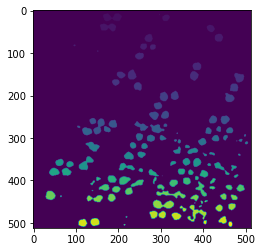

In [148]:
imshow(selected_labeled_data)

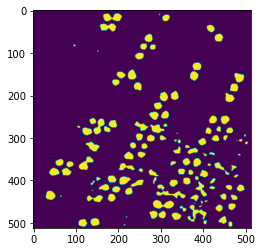

In [149]:
binary_mask_data = ImageController.binary_mask(selected_labeled_data)
ImageController.display(binary_mask_data)

In [150]:
from skimage import measure, filters

binary_mask_closed = mh.morph.close(binary_mask_data)
labeled_result, nr_objects_result = mh.label(binary_mask_closed)
labeled_result = mh.labeled.remove_bordering(labeled_result)
region_sizes = measure.regionprops(labeled_result, intensity_image=binary_mask_closed)

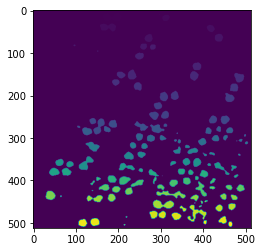

In [151]:
ImageController.display(labeled_result)

In [152]:
import math

16.765217391304347 186.0486956521739
575
123.88225099390857
2.123931311494599
(165, 209, 209, 165, 165) (8, 8, 27, 27, 8)
region greater than min region size
10.0 296.5
6
6.0
0.477464829275686
(296, 298, 298, 296, 296) (9, 9, 12, 12, 9)
17.89903846153846 311.8269230769231
208
51.21320343559643
1.0034383276668453
circular region
(304, 321, 321, 304, 304) (11, 11, 26, 26, 11)
region greater than min region size
39.929577464788736 176.08249496981892
497
105.7401153701776
1.7902484528502003
(157, 195, 195, 157, 157) (32, 32, 51, 51, 32)
region greater than min region size
42.70762711864407 417.021186440678
236
55.698484809834994
1.0460799907797942
circular region
(408, 427, 427, 408, 408) (35, 35, 52, 52, 35)
region greater than min region size
65.52941176470588 271.37867647058823
272
60.284271247461895
1.0632349951652407
circular region
(262, 281, 281, 262, 262) (56, 56, 75, 75, 56)
region greater than min region size
64.62717770034843 436.03484320557493
287
61.4558441227157
1.04721201359

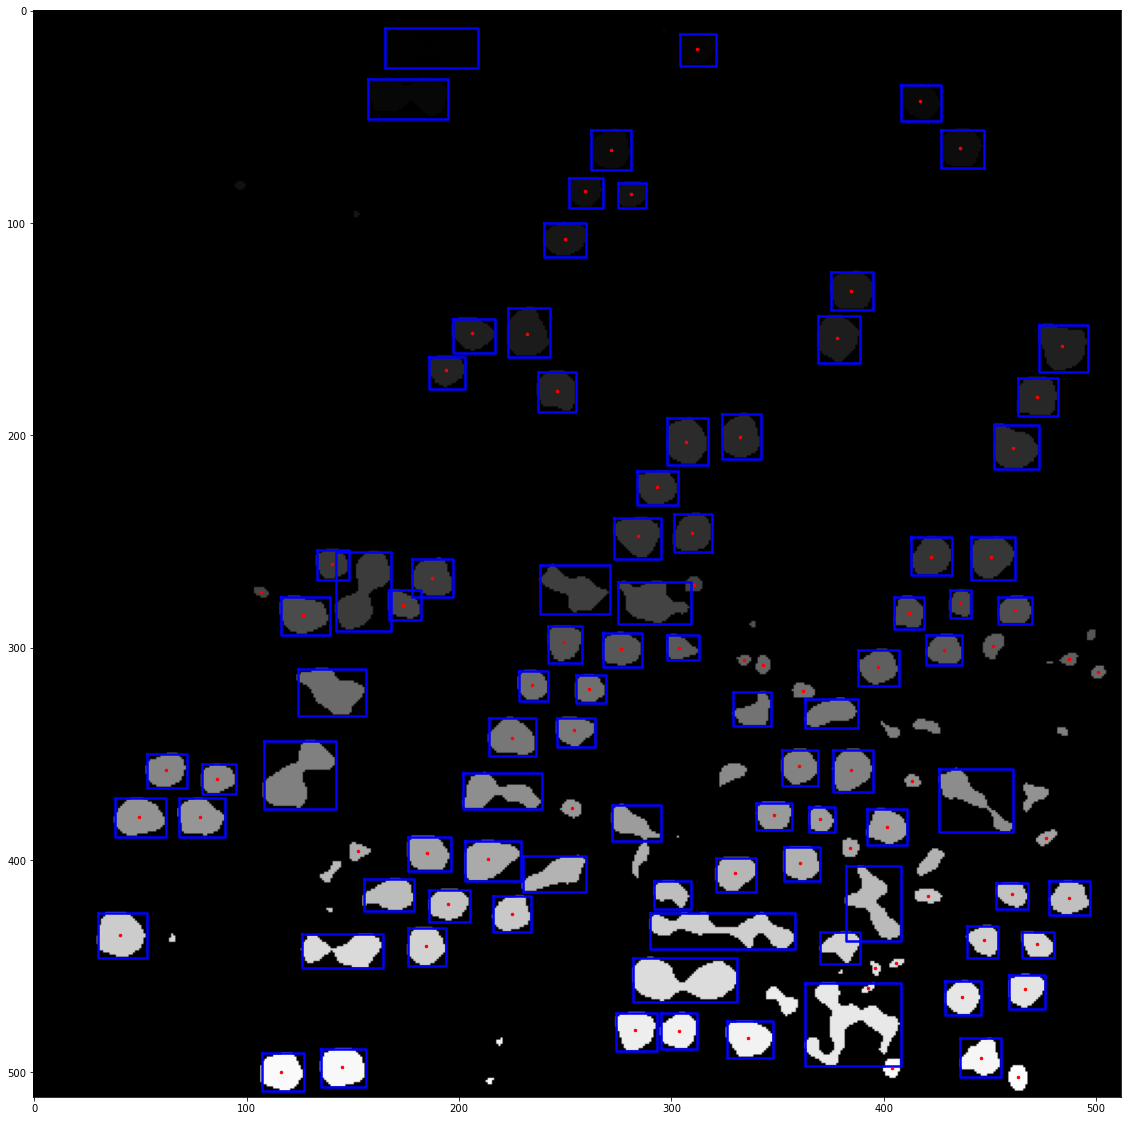

In [182]:
f, ax = plt.subplots(figsize=(20,20))
ax.imshow(labeled_result, cmap='gray')

large_regions = 0
min_region_size = 100
num_circles = 0
num_sq = 0
for region in region_sizes:
    x1, y1 = region.centroid
    print(x1, y1)
    print(region.area)
    print(region.perimeter)
    circularity = (region.perimeter ** 2) / (4 * math.pi * region.area);
    print(circularity)
    if circularity < 1.2 and circularity > 0.8:
        print("circular region")
        ax.plot(y1, x1, '.r', markersize=5)
        num_circles += 1
    minr, minc, maxr, maxc = region.bbox
    x = maxc - minc
    y = maxr - minr
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    print(bx, by)
    if x/y >= .7 and x/y <= 1.3:
        num_sq += 1
    if region.area > min_region_size:
        large_regions += 1
        print('region greater than min region size')
        ax.plot(bx, by, '-b', linewidth=2.5)
print("possible number of rhabdomeres: ", num_circles)
print("possible number of rhabdomeres: ", num_sq)

In [263]:
max(areas)

747

In [264]:
nr_objects_result, large_regions

(169, 99)

In [74]:
a = file_path.split('.')[0] + '.png'

In [75]:
a

'/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/wild_type_raw/000000_000000_000447_000000.png'

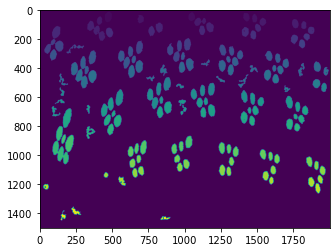

In [78]:
imshow(selected_labeled_data)

In [79]:
plt.show()

In [80]:
dir_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/wild_type_raw/'

In [81]:
files = os.listdir(dir_path)

In [85]:
file = files[1]

In [86]:
plot_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/wild_type_cs_1/binary_mask_3/compare_plots/'

In [87]:
plot_name = os.path.join(plot_path, file)

In [88]:
plot_name

'/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/wild_type_cs_1/binary_mask_3/compare_plots/000000_000000_000100_000000.tif'

In [89]:
plot_name = plot_name.split('.')[0] + '.png'

In [90]:
plot_name

'/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/wild_type_cs_1/binary_mask_3/compare_plots/000000_000000_000100_000000.png'

In [69]:
img_file_names = sorted(os.listdir('/raid/mpsych/RISTERLAB/NINA_D1_MUTANT/VSOverviewTileSet/Acquired/'))

In [70]:
len(img_file_names)

4338

In [71]:
img_files = []
for name in img_file_names:
    if name.endswith('.tif'):
        img_files.append(name)

In [72]:
len(img_files)

2169

In [73]:
img_files[0]

'000000_000000_000000_000000.tif'

In [74]:
imgs = img_files[900:]

In [75]:
len(imgs)

1269

In [76]:
random_list = random.sample(range(1, len(imgs)), 300)

In [82]:
indices = sort(random_list)

In [83]:
for i in indices:
    source_file = os.path.join('/raid/mpsych/RISTERLAB/NINA_D1_MUTANT/VSOverviewTileSet/Acquired/', imgs[i])
    destination_file = os.path.join('/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/nina_d1_raw/', imgs[i])
    
    shutil.copy(source_file, destination_file)

In [ ]:
save_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_2/'
log_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_2/log.txt'
plot_path = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/04-14/nina_d1_mutant/binary_mask_2/compare_plots/'

# Following values are hardcoded in the pipeline
# crop size - (512, 512)
# threshold range - mean plus 20
# region size - 750 - removes regions less than this size
# metric related -
# minimum region size - consider a relevant region only if size more than 3000
# nr_objects_binary - this value should lie between 170 and 210
# large_regions - this value should lie between 80 and 100

is_segmentation_bad = True
good_image_count, bad_image_count = 0, 0
file_count = 1
for file in tqdm(sorted(os.listdir(dir_path))):
    start_time = time.time()
    if file.endswith(".tif"):
        print("Image Name: " + file)
        img_file = os.path.join(dir_path, file)
        data = ImageController.read(img_file)
        normalized_data = ImageController.normalize(data)
        crop_data = ImageController.center_crop(normalized_data, crop_size=(512, 512))
        data_crop = ImageController.center_crop(data, crop_size=(512, 512))
        smoothed_data = ImageController.smooth(crop_data)
        threshold_value = int(smoothed_data.mean())
        threshold_limit = int(threshold_value) + 20
        for threshold in tqdm(range(threshold_value, threshold_limit, 1)):
            threshold_data = ImageController.threshold(smoothed_data, threshold_value=threshold)
            labeled_data, nr_count = ImageController.label(threshold_data)
            selected_labeled_data = ImageController.select_large_regions(labeled_data, region_size=750)
            binary_mask_data = ImageController.binary_mask(selected_labeled_data)
            closed_binary_mask_data = ImageController.close_binary_mask(binary_mask_data)
            segmented_image = ImageController.binary_image(closed_binary_mask_data)
            nr_objects_binary, large_regions = ImageController.classify_image_nina(binary_mask_data)
            print("nr_objects_binary: ", nr_objects_binary, " large_regions: ", large_regions)
            if 190 <= nr_objects_binary <= 210 and 80 <= large_regions <= 120:
                print("+++++++++++++++")
                print("Threshold value: ", threshold)
                print("Intensity mean: ", smoothed_data.mean())
                binary_mask_path = os.path.join(save_path,file)
                ImageController.display_compare(data_crop, segmented_image)
                # ImageController.save(binary_mask_path, segmented_image)
                plot_name = os.path.join(plot_path, file)
                plot_name = plot_name.split('.')[0] + '_' + str(time.time()) + '.png'
                ImageController.save_compare(data_crop, segmented_image, plot_name)
                good_image_count = good_image_count + 1
                is_segmentation_bad = False
            else:
                ImageController.display(segmented_image)
        end_time = time.time()
        if is_segmentation_bad:
            bad_image_count = bad_image_count + 1
            is_segmentation_bad = True
        print("Total Time Taken: ", (end_time - start_time), " seconds")
        print("Good image count so far: ", good_image_count)
        print("Bad image count so far: ", bad_image_count)
        print("Good and bad image total: ", str(good_image_count + bad_image_count))
        print("Total files processed so far: ", file_count)
        file_count = file_count + 1
        print("---------------------------------------------------------")